In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
from simsetup import get_sim
from modelfitting import ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [2]:
datapath = '../training_data/'
csvpath = '../csvs/'
dset = 'resonant/'
Norbits = 1e4
Nout = 80
featureargs = (Norbits, Nout) # params to pass feature function
featurefolder = 'featuresNorbits{0:.1f}Nout{1}trio/'.format(Norbits, Nout)
trainingdatafolder = datapath+dset+featurefolder
csvfolder = csvpath+dset
print(trainingdatafolder)
print(csvfolder)

../training_data/resonant/featuresNorbits10000.0Nout80trio/
../csvs/resonant/


In [3]:
dataset = pd.read_csv(trainingdatafolder+"trainingdata.csv", index_col = 0)
labels = pd.read_csv(trainingdatafolder+"labels.csv", index_col=0)

In [4]:
def hasnull(row):
    numnulls = row.isnull().sum()
    if numnulls == 0:
        return 0
    else:
        return 1

def tmax(row):
    #sim = get_sim(row, csvfolder)
    tmax = 1e4 # replace with a calculation of tmax
    return tmax

In [5]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']

features = near + far + megno

add columns for tmax and hasnull manually

In [6]:
%%time
if 'tmax' not in dataset.columns:
    dataset['hasnull'] = dataset.apply(hasnull, axis=1)
    dataset['tmax'] = dataset.apply(tmax, axis=1)
    # dataset['tmax'] = dataset.apply(lambda x:1e4, axis=1) # this version would just set tmax=1e4 for all of them

    dataset.to_csv(trainingdatafolder+"trainingdata.csv", encoding='ascii')

CPU times: user 18 µs, sys: 0 ns, total: 18 µs
Wall time: 18.8 µs


Now we do the filtering manually. This is taking only systems with instability times > 1e4 AND no NaNs. Would adjust this for each case. 

We were worried that we were using filter=..., which was filtering out any rows that had any NaNs in them. We wanted to compare results when we don't include that filter, and only filtered for instability_time.

In [8]:
mask = (labels['instability_time'] > 1.e4) & (dataset['hasnull'] == 0)
y = labels[mask]['Stable']
X = dataset[mask][features]
tinst = labels[mask]['instability_time']

Now we do the train test split manually. We take 80\% of the rows for training, 20\% for testing (this is what we were doing before too)

In [9]:
Nrows = int(0.8*X.shape[0])
trainX = X.iloc[:Nrows, :]
trainY = y.iloc[:Nrows]
testX = X.iloc[Nrows:, :]
testY = y.iloc[Nrows:]
test_tinst = tinst.iloc[Nrows:]

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

In [18]:
space ={'max_depth': hp.qloguniform('x_max_depth', np.log(5), np.log(20), 1),
        'min_child_weight': hp.loguniform('x_min_child', 0, np.log(20)),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
}

def objective(params):
    clf = XGBClassifier(n_jobs=16, n_estimators = 50,
                            max_depth = int(params['max_depth']), 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            learning_rate = 0.15, seed = 0)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    print("SCORE:", avg_score, "ERROR", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}


In [21]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 100, trials = trials, rstate=np.random.default_rng(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                                                          
0.8996161435223005                                                              
ERROR                                                                           
0.002553384628378213                                                            
SCORE:                                                                          
0.8944143145554433                                                              
ERROR                                                                           
0.0023055840529328225                                                           
SCORE:                                                                          
0.9067621333841573                                                              
ERROR                                                                           
0.0026797508813091427                                                           
SCORE:                      

0.9080559595467064                                                              
ERROR                                                                           
0.002365265979831565                                                            
SCORE:                                                                          
0.9080910562151369                                                              
ERROR                                                                           
0.00227028291104302                                                             
SCORE:                                                                          
0.9060811355910376                                                              
ERROR                                                                           
0.0023369168041066507                                                           
SCORE:                                                                          
0.9082972266434748          

ERROR                                                                           
0.002456854080035791                                                            
SCORE:                                                                          
0.8949154515440737                                                              
ERROR                                                                           
0.0024654158336103586                                                           
SCORE:                                                                          
0.9077530018020589                                                              
ERROR                                                                           
0.002565015130232415                                                            
SCORE:                                                                          
0.9001303443687858                                                              
ERROR                       

0.002460411428390525                                                            
SCORE:                                                                          
0.9070131247247858                                                              
ERROR                                                                           
0.0026566464670273312                                                           
SCORE:                                                                          
0.9078566830577053                                                              
ERROR                                                                           
0.002366744748362913                                                            
SCORE:                                                                          
0.9078993436766531                                                              
ERROR                                                                           
0.002378405635432096        

# max_depth controls depth of trees

12 lets the model use all the features and improvements seem minor beyond that

Text(0, 0.5, 'CV AUC')

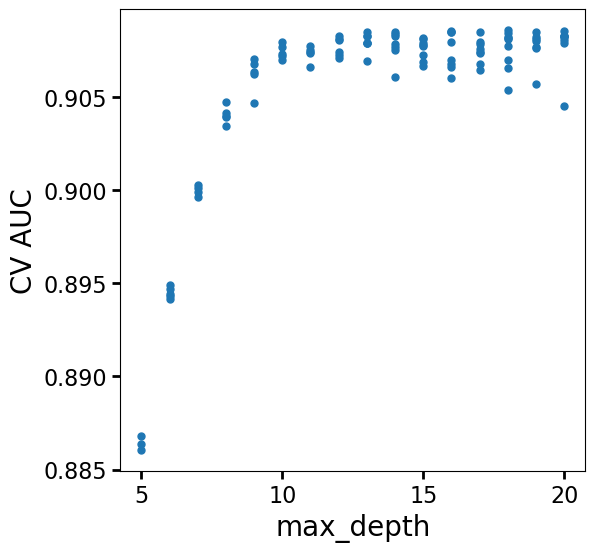

In [22]:
depths = trials.vals['x_max_depth']
min_childs = trials.vals['x_min_child']
aucs = np.array([1-x['loss'] for x in trials.results])

fig, ax = plt.subplots()
ax.plot(depths, aucs, '.')
ax.set_xlabel('max_depth')
ax.set_ylabel('CV AUC')

# min child weight acts as a regularizer, penalizing complex models. Larger min_child_weight = larger penalization

Text(0, 0.5, 'CV AUC')

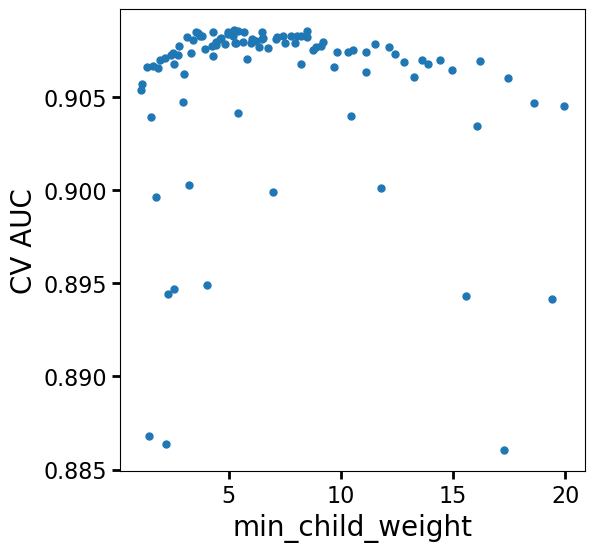

In [23]:
fig, ax = plt.subplots()
ax.plot(min_childs, aucs, '.')
ax.set_xlabel('min_child_weight')
ax.set_ylabel('CV AUC')

Text(0, 0.5, 'min_child_weight')

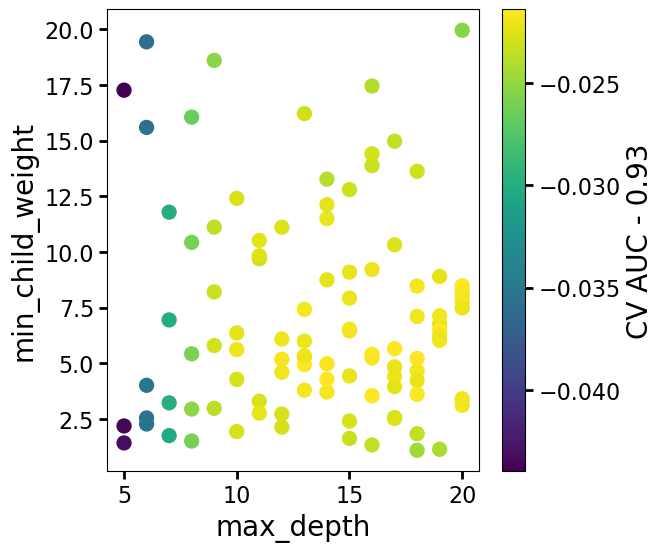

In [24]:
fig, ax = plt.subplots()
cb = ax.scatter(depths, min_childs, c=aucs-0.93)
plt.colorbar(cb, label='CV AUC - 0.93')
ax.set_xlabel('max_depth')
ax.set_ylabel('min_child_weight')

# Marginal improvements beyond max_depth of 13, so choose the least complex model

In [25]:
model = XGBClassifier(learning_rate = 0.03, 
                         max_depth = 20, 
                         subsample = 0.95,
                         min_child_weight = 5)

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=400)

[0]	train-auc:0.92868+0.00081	test-auc:0.89039+0.00293
[1]	train-auc:0.93903+0.00055	test-auc:0.89937+0.00334
[2]	train-auc:0.94360+0.00036	test-auc:0.90350+0.00311
[3]	train-auc:0.94572+0.00053	test-auc:0.90555+0.00281
[4]	train-auc:0.94733+0.00058	test-auc:0.90651+0.00272
[5]	train-auc:0.94871+0.00061	test-auc:0.90756+0.00241
[6]	train-auc:0.95000+0.00071	test-auc:0.90848+0.00217
[7]	train-auc:0.95118+0.00076	test-auc:0.90946+0.00212
[8]	train-auc:0.95223+0.00085	test-auc:0.91026+0.00178
[9]	train-auc:0.95321+0.00076	test-auc:0.91074+0.00170
[10]	train-auc:0.95398+0.00069	test-auc:0.91127+0.00180
[11]	train-auc:0.95474+0.00078	test-auc:0.91166+0.00165
[12]	train-auc:0.95561+0.00064	test-auc:0.91195+0.00158
[13]	train-auc:0.95636+0.00051	test-auc:0.91249+0.00166
[14]	train-auc:0.95716+0.00049	test-auc:0.91294+0.00172
[15]	train-auc:0.95791+0.00049	test-auc:0.91328+0.00182
[16]	train-auc:0.95860+0.00044	test-auc:0.91369+0.00180
[17]	train-auc:0.95920+0.00043	test-auc:0.91407+0.00189
[1

[146]	train-auc:0.99311+0.00011	test-auc:0.92735+0.00174
[147]	train-auc:0.99320+0.00011	test-auc:0.92738+0.00174
[148]	train-auc:0.99331+0.00011	test-auc:0.92742+0.00175
[149]	train-auc:0.99340+0.00011	test-auc:0.92747+0.00173
[150]	train-auc:0.99349+0.00012	test-auc:0.92750+0.00173
[151]	train-auc:0.99358+0.00011	test-auc:0.92754+0.00175
[152]	train-auc:0.99367+0.00011	test-auc:0.92758+0.00177
[153]	train-auc:0.99377+0.00011	test-auc:0.92766+0.00180
[154]	train-auc:0.99388+0.00011	test-auc:0.92774+0.00182
[155]	train-auc:0.99396+0.00011	test-auc:0.92778+0.00182
[156]	train-auc:0.99405+0.00011	test-auc:0.92785+0.00181
[157]	train-auc:0.99412+0.00011	test-auc:0.92787+0.00182
[158]	train-auc:0.99420+0.00010	test-auc:0.92792+0.00180
[159]	train-auc:0.99427+0.00010	test-auc:0.92798+0.00181
[160]	train-auc:0.99434+0.00012	test-auc:0.92801+0.00182
[161]	train-auc:0.99442+0.00013	test-auc:0.92805+0.00184
[162]	train-auc:0.99450+0.00012	test-auc:0.92808+0.00182
[163]	train-auc:0.99459+0.00011

[290]	train-auc:0.99909+0.00005	test-auc:0.93100+0.00180
[291]	train-auc:0.99911+0.00005	test-auc:0.93101+0.00180
[292]	train-auc:0.99912+0.00005	test-auc:0.93100+0.00181
[293]	train-auc:0.99913+0.00005	test-auc:0.93101+0.00181
[294]	train-auc:0.99914+0.00005	test-auc:0.93102+0.00182
[295]	train-auc:0.99916+0.00005	test-auc:0.93102+0.00182
[296]	train-auc:0.99917+0.00005	test-auc:0.93105+0.00183
[297]	train-auc:0.99918+0.00005	test-auc:0.93105+0.00182
[298]	train-auc:0.99920+0.00005	test-auc:0.93107+0.00181
[299]	train-auc:0.99921+0.00005	test-auc:0.93107+0.00180
[300]	train-auc:0.99922+0.00005	test-auc:0.93109+0.00180
[301]	train-auc:0.99923+0.00005	test-auc:0.93110+0.00180
[302]	train-auc:0.99924+0.00005	test-auc:0.93111+0.00180
[303]	train-auc:0.99925+0.00005	test-auc:0.93112+0.00179
[304]	train-auc:0.99926+0.00005	test-auc:0.93113+0.00179
[305]	train-auc:0.99928+0.00005	test-auc:0.93114+0.00179
[306]	train-auc:0.99929+0.00005	test-auc:0.93114+0.00179
[307]	train-auc:0.99930+0.00005

# Going beyond ~100 trees does not improve CV, so cut off training there to avoid overfitting

Text(0, 0.5, 'CV AUC score')

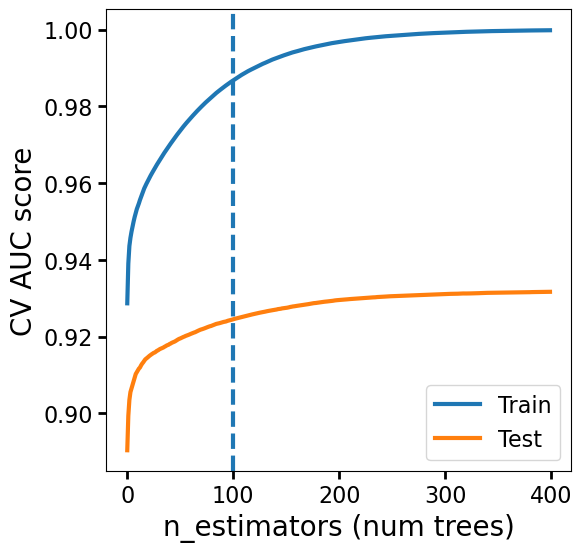

In [26]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-auc-mean'], label='Train')
ax.plot(score.index, score['test-auc-mean'], label='Test')
ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

In [27]:
model.set_params(n_estimators = n_estimators)
model.fit(trainX, trainY)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [28]:
model.save_model(datapath+'../spock/models/spock_test.json')

# SPOCK

In [10]:
model = XGBClassifier()
model.load_model(datapath+'../spock/models/spock_test.json')

Text(0.5, 1.0, 'ROC curve (AUC = 0.926)')

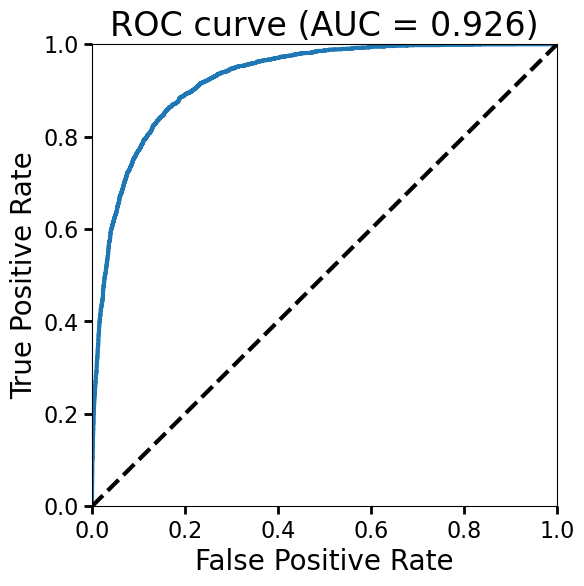

In [11]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testX, testY)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [12]:
stride = 10
np.savetxt('../spock/models/resROC.txt', (ROCthresholds[::stride], tpr[::stride], fpr[::stride]))

In [13]:
ROCthresholds, tpr, fpr = np.loadtxt('../spock/models/resROC.txt')
for i in range(0,len(tpr), 15):
    print("Threshold {0}, TPR = {1}, FPR = {2}".format(ROCthresholds[i], tpr[i], fpr[i]))

Threshold 1.9532307386398315, TPR = 0.0, FPR = 0.0
Threshold 0.8128209710121155, TPR = 0.2904746934926124, FPR = 0.0093042071197411
Threshold 0.7329307198524475, TPR = 0.41716441370638163, FPR = 0.018406148867313916
Threshold 0.662153959274292, TPR = 0.5014146494812952, FPR = 0.028418284789644012
Threshold 0.5952372550964355, TPR = 0.5787488211254322, FPR = 0.03873381877022654
Threshold 0.5399468541145325, TPR = 0.6337629676202452, FPR = 0.051678802588996764
Threshold 0.4822671115398407, TPR = 0.6862621817038667, FPR = 0.06533171521035598
Threshold 0.42907005548477173, TPR = 0.7321596982081107, FPR = 0.08151294498381877
Threshold 0.37937161326408386, TPR = 0.7692549512731846, FPR = 0.09961569579288027
Threshold 0.3238004148006439, TPR = 0.8060358377868595, FPR = 0.12125809061488674
Threshold 0.27298399806022644, TPR = 0.8409305249921408, FPR = 0.1469457928802589
Threshold 0.225220188498497, TPR = 0.8717384470292361, FPR = 0.1787014563106796
Threshold 0.17599506676197052, TPR = 0.900974

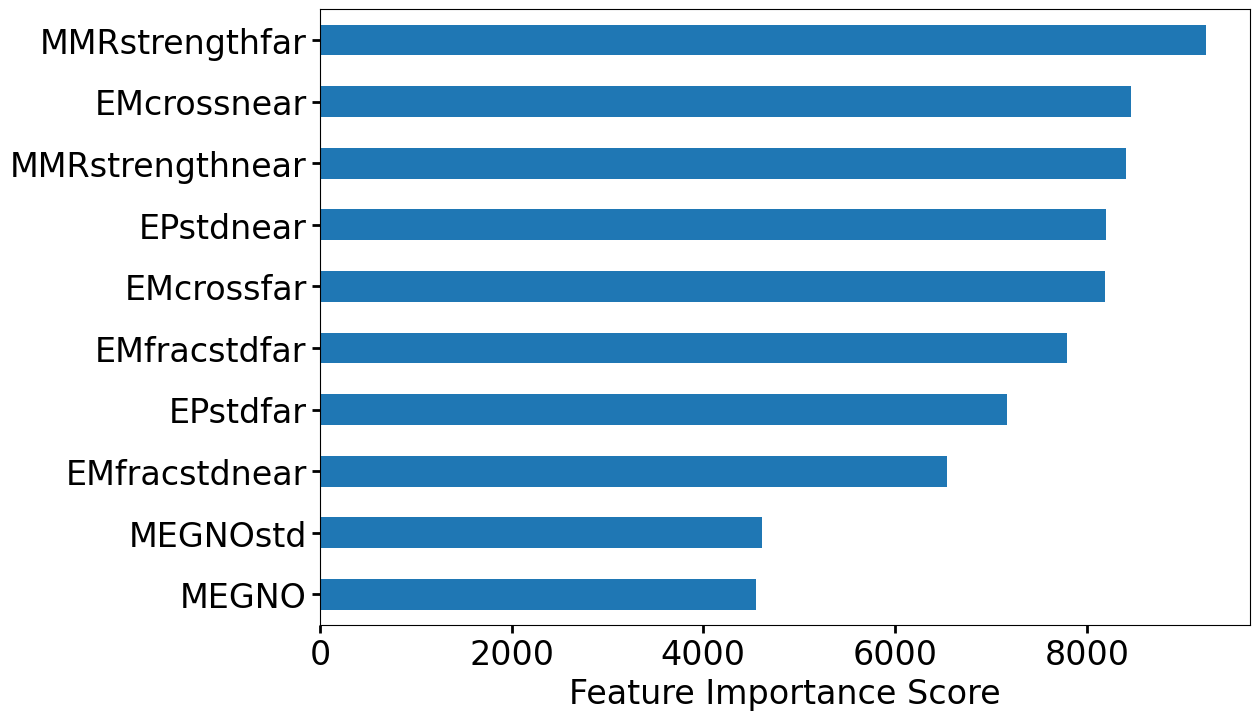

In [14]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

In [15]:
feat_imp

MMRstrengthfar     9240.0
EMcrossnear        8464.0
MMRstrengthnear    8407.0
EPstdnear          8201.0
EMcrossfar         8189.0
EMfracstdfar       7789.0
EPstdfar           7170.0
EMfracstdnear      6537.0
MEGNOstd           4613.0
MEGNO              4550.0
dtype: float64

In [16]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, confusion_matrix, auc
from sklearn import metrics

[0.04033014 0.6083133  0.08164801 ... 0.5973528  0.36730555 0.0246543 ]


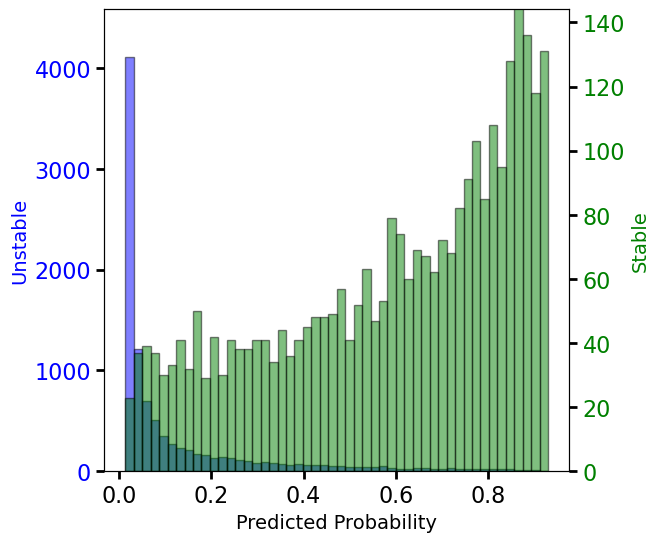

In [17]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(model, testX, testY)
print(Unstable)

fig, ax1 = plt.subplots()
n, bins, patches = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    
ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
       
ax1.set_ylim([0,35*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100
fig.savefig('stable_unstable_comparison.png')

Text(0, 0.5, 'Fraction actually stable')

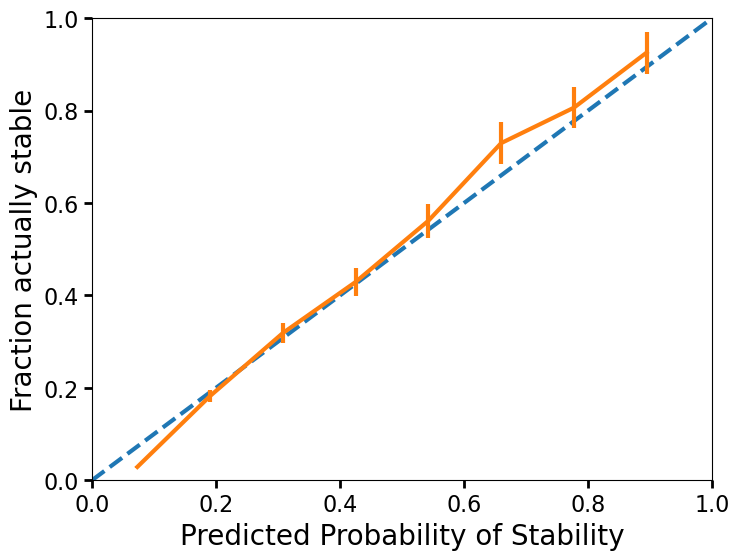

In [18]:
bincenters, fracstable, errorbars = calibration_plot(model, testX, testY, bins=8)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

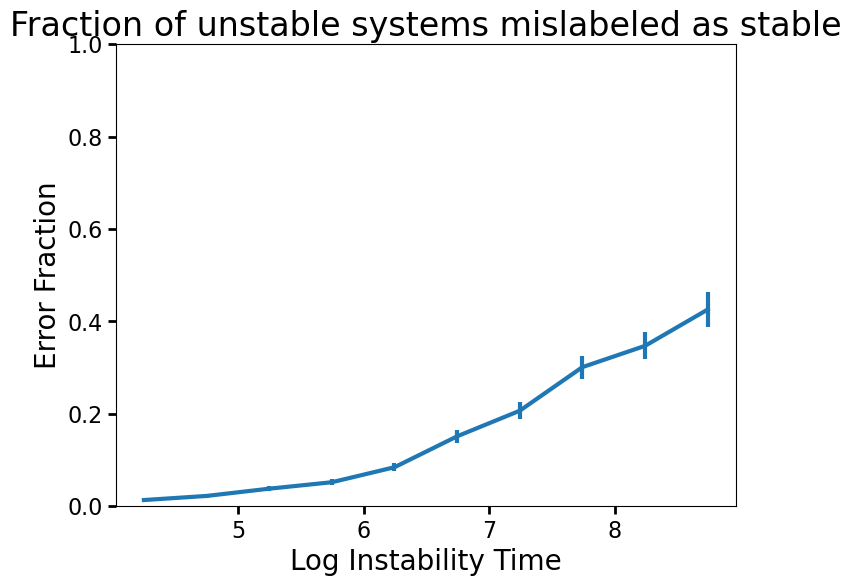

In [19]:
thresh = 0.34 # for 10% FPR
bincenters, errorfracs, errorbars = unstable_error_fraction(model, testX, testY, test_tinst, thresh, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')